# Text2Cypher Workflow Demo Notebook

This notebooks demonstrates a text2cypher workflow with visualization capabilities.

It also does not use an LLM to validate generated Cypher. Instead it uses the Cypher validation functions from the ps_genai_agents package.

This workflow uses similarity search to collect the most relevant Cypher examples for the Cypher generation step.

In [16]:
import sys

DIR_SHIFT = "../../"
sys.path.append(DIR_SHIFT)

## Imports

In [17]:
import nest_asyncio

nest_asyncio.apply()

In [18]:
import asyncio
import os

from IPython.display import Image, display
from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from neo4j import GraphDatabase

from ps_genai_agents.components.state import OutputState
from ps_genai_agents.retrievers.cypher_examples import (
    Neo4jVectorSearchCypherExampleRetriever,
)
from ps_genai_agents.workflows.multi_agent import (
    create_text2cypher_with_visualization_workflow,
)

## Neo4j Graph

This class handles interaction with our Neo4j database. We use `enhanced_schema` to gain more detail about the graph contents.

In [19]:
from dotenv import load_dotenv

load_dotenv()

True

In [20]:
graph = Neo4jGraph(enhanced_schema=True)

In [21]:
print(graph.schema)

Node properties:
- **Customer**
  - `id`: STRING Example: "9A79438B"
  - `ageBucket`: STRING Example: ">=70"
  - `gender`: STRING Available options: ['Male', 'Female', '']
- **Category**
  - `id`: STRING Available options: ['Exterior', 'Driving Experience', 'Features/Controls/Displays (FCD)', 'Driving Assistance', 'Infotainment', 'Seats', 'Climate', 'Interior', 'Powertrain']
- **Problem**
  - `id`: STRING Example: "EXT01"
  - `problem`: STRING Example: "EXT01: Doors - Hard to open/close"
- **Question**
  - `id`: INTEGER Min: 1, Max: 223
  - `question`: STRING Example: "#001 Doors Hard to Open/Close"
- **Vehicle**
  - `id`: STRING Example: "Acura Integra"
  - `totalProblems`: INTEGER Min: 2, Max: 10
- **Verbatim**
  - `id`: STRING Example: "9A79438B"
  - `verbatim`: STRING Example: "When the doors are locked and the driver's door is"
  - `verbatimText`: STRING Example: "acura integra exterior ext01: doors - hard to open"
  - `severity`: FLOAT Example: "1.0"
  - `gender`: STRING Example:

## LLM

We will be using an OpenAI LLM for this demo.

In [22]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Cypher Example Retriever

This class is responsible for collecting and formatting Cypher examples for few shot prompting.

Here we are selecting the k most similar examples from a vector store containing many Cypher examples. 
This allows us to have a larger functional scope while reducing the number of tokens sent to the LLM for processing.

In [23]:
embedder = OpenAIEmbeddings(model="text-embedding-ada-002")

In [24]:
neo4j_driver = GraphDatabase.driver(
    uri=os.getenv("NEO4J_URI"),
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD")),
)
vector_index_name = "cypher_query_vector_index"

In [25]:
cypher_query_yaml_file_path = DIR_SHIFT + "./data/iqs/queries/queries.yml"
cypher_example_retriever = Neo4jVectorSearchCypherExampleRetriever(
    neo4j_driver=neo4j_driver, vector_index_name=vector_index_name, embedder=embedder
)

## Agent

In [26]:
scope_description = "This application may answer questions related to customer feedback on Honda vehicles."

In [27]:
agent = create_text2cypher_with_visualization_workflow(
    llm=llm,
    graph=graph,
    scope_description=scope_description,
    cypher_example_retriever=cypher_example_retriever,
    # where llm cypher validation is turned off
    llm_cypher_validation=False,
    attempt_cypher_execution_on_final_attempt=True,
)

Here we can see the agent workflow. 
* The workflow always starts at `guardrails` where the input question is determined to be in scope or not.
* The workflow always ends at `final_answer` where the generated contents are formatted to be returned to the user.
* Dotted lines indicate conditional paths.

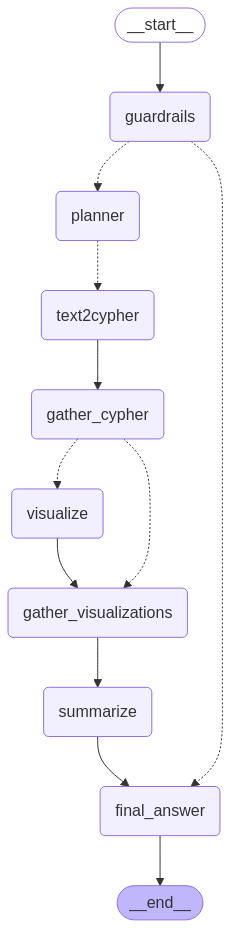

In [28]:
display(Image(agent.get_graph().draw_mermaid_png()))

## Questions

### Helper Functions

In [29]:
async def ask_question(question: str, debug: bool = False) -> OutputState:
    """wrapper to simplify asking questions in the notebook."""

    async def ask():
        response = await agent.ainvoke({"question": question}, debug=debug)
        return response

    return asyncio.run(ask())


def print_answer(response: OutputState) -> None:
    print(response.get("question"))
    print(response.get("answer"))


def print_cypher_queries(response: OutputState) -> None:
    [
        print(c.get("task") + "\n\n" + c.get("statement") + "\n\n")
        for c in response.get("cyphers")
    ]


def print_cypher_results(response: OutputState) -> None:
    [
        (
            print(c.get("task") + "\n\n"),
            [print(r) for r in c.get("records")],
            print("\n\n"),
        )
        for c in response.get("cyphers")
    ]


def print_viz_results(response: OutputState) -> None:
    [
        (
            print(v.get("task") + "\n\n" + v.get("chart_description") + "\n\n"),
            display(v.get("chart")),
        )
        for v in response.get("visualizations")
    ]

The agent response is a Python dictionary with the following format:
```python
{
    answer: str,
    question: str,
    steps: List[str],
    cyphers: List[
        subquestion: str,
        statement: str,
        errors: List[str],
        records: List[Dict[str, Any]],
        next_action: str,
        steps: List[str],
    ],
    visualizations: List[
        subquestion: str
        chart: Any
        chart_description: str
        steps: List[str]
    ]
}
```

### 1. Out of Scope

The agent can detect whether a question is in scope and avoid further processing.

In [15]:
q1 = await ask_question("What are the most common apple types?")

In [16]:
print_answer(q1)

What are the most common apple types?
This question is out of scope. Therefore I cannot answer this question.


We can see the agent only performs 2 steps - only `guardrails` requires an LLM call.

In [17]:
q1.get("steps")

['guardrails', 'final_answer']

### 2. Cypher Question without Visualization

The agent is capable of creating Cypher queries to answer questions within the scope of the data.

In [ ]:
q2 = await ask_question("How many vehicles are there?", debug=False)

In [19]:
print_answer(q2)

How many vehicles are there?
There are 12 vehicles.


All Cypher queries are saved for evaluation.

In [20]:
print_cypher_queries(q2)

What is the total number of vehicles?

MATCH (v:Vehicle)
RETURN COUNT(v) AS totalVehicles




Results are saved as well for evaluation or futher processing.

In [21]:
print_cypher_results(q2)

What is the total number of vehicles?


{'totalVehicles': 12}





In [22]:
q2.get("steps")

['guardrails',
 'planner',
 ['generate_cypher', 'validate_cypher', 'execute_cypher'],
 'gather_cypher',
 'gather_visualizations',
 'summarize',
 'final_answer']

### 3. Multi-Cypher Query Question without Visualization

The agent is capable of splitting the input question into multiple subquestions. These will be individually addressed with their own Cypher queries. 
The final answer will summarize the query results together.

In [17]:
q3 = await ask_question(
    "Summarize the responses under fcd10 for honda pilot. What is the men to women proportion for these responses and what is the problem for fcd10?",
    debug=False,
)

In [18]:
print_answer(q3)

Summarize the responses under fcd10 for honda pilot. What is the men to women proportion for these responses and what is the problem for fcd10?
- **Summary of Responses under FCD10 for Honda Pilot:**
  - Users report that the touch system to lock and unlock doors is unreliable, often requiring multiple attempts or manual intervention.
  - Some users experience issues where doors do not unlock from the outside, necessitating entry from another door.
  - The auto-lock feature sometimes fails to lock the doors when the key fob is out of range.
  - There are instances where the door locks instead of unlocking when the handle is touched.
  - If someone tries to open the door while it is being unlocked, it may remain locked and become unresponsive for a few minutes.

- **Men to Women Proportion:**
  - Male to Female Ratio: 0.4

- **Problem for FCD10:**
  - Door locks - Broken/work inconsistently


In [25]:
print_cypher_queries(q3)

Summarize the responses under fcd10 for Honda Pilot, including the problem for fcd10.

MATCH (p:Problem {id: "FCD10"})<-[:HAS_PROBLEM]-(v:Verbatim {make: "Honda", model: "Pilot"})
RETURN p.problem AS problem, COLLECT(v.verbatim) AS responses


Determine the men to women proportion for the responses under fcd10 for Honda Pilot.

MATCH (p:Problem {id: "FCD10"})<-[:HAS_PROBLEM]-(v:Verbatim {make: "Honda", model: "Pilot"})
WITH COUNT(v) AS totalResponses,
     SUM(CASE WHEN v.gender = "Male" THEN 1 ELSE 0 END) AS males,
     SUM(CASE WHEN v.gender = "Female" THEN 1 ELSE 0 END) AS females
RETURN totalResponses, males, females, toFloat(males) / (CASE WHEN females = 0 THEN 1 ELSE females END) AS maleToFemaleRatio




### 4. Question with Visualization

If visualization is requested, the agent will attempt to create either a bar, line or scatter plot to fit the results gathered from Neo4j.

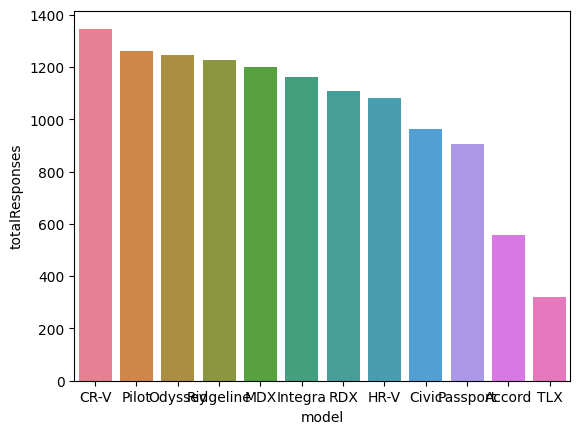

In [30]:
q4 = await ask_question("Show me in a chart which models have the most responses.", debug=False)

We recieve a description along with each generated chart.

Create a chart showing which models have the most responses.

This bar chart displays the total number of responses for each car model, highlighting which models have the most responses. Each bar represents a different car model, with the height of the bar corresponding to the total number of responses received for that model.




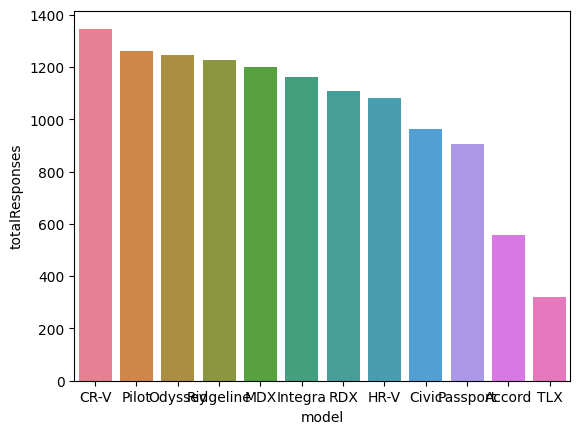

In [31]:
print_viz_results(q4)

We still recieve everything else in the result such as the summary and Cypher info.

In [32]:
print_answer(q4)

Show me in a chart which models have the most responses.
- **CR-V**: 1347 responses
- **Pilot**: 1261 responses
- **Odyssey**: 1245 responses
- **Ridgeline**: 1228 responses
- **MDX**: 1199 responses
- **Integra**: 1163 responses
- **RDX**: 1110 responses
- **HR-V**: 1080 responses
- **Civic**: 965 responses
- **Passport**: 904 responses
- **Accord**: 559 responses
- **TLX**: 319 responses


In [33]:
print_cypher_queries(q4)

Create a chart showing which models have the most responses.

MATCH (v:Verbatim)
WITH v.model AS model, COUNT(v) AS totalResponses
RETURN model, totalResponses
ORDER BY totalResponses DESC




In [34]:
q4.get("steps")

['guardrails',
 'planner',
 ['generate_cypher', 'validate_cypher', 'execute_cypher'],
 'gather_cypher',
 ['generate_chart_details',
  'validate_chart_details',
  'correct_chart_details',
  'validate_chart_details',
  'generate_chart'],
 'gather_visualizations',
 'summarize',
 'final_answer']